In [1]:
import torch 
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable

from dataset.readVideo import DramaDataset
from utils.tokenMaker import Lang
from utils.tool import padding
import pickle
import os
import matplotlib.pyplot as plt
from Similarity.model import GesdSimilarity
useCuda = True
device = torch.device("cuda" if useCuda else "cpu")

In [2]:
DataDir="/home/ball/Videos/BrokeEN"
datasets = DramaDataset(basedir=DataDir,
                        maxFrame=0,
                        )
import random
def getSample(size):
    imgs = []
    pres = []
    nexs = []
    for i in range(size):
        pre, nex, img = random.choice(datasets)
        imgs.append(img)
        pres.append(pre)
        nexs.append(nex)
    return pres, nexs, imgs

def makeNegSample(pres, nexs, negSize):
    mpres = []
    mnexts = []
    scores = []
    for pre, nex in zip(pres, nexs):
        while True:
            negs = random.sample(nexs, negSize)
            if not nex in negs:
                break
        mpres +=[pre] * (negSize + 1)
        mnexts += [nex] + negs
        scores += [1] + [0] * negSize
    return mpres, mnexts, scores
vectorTransforms = [lambda x: torch.LongTensor(x).to(device)]
def sentenceToVector(sentences, lang, sos=False, eos=False):
    vectors = []
    for s in sentences:
        vectors.append(lang.sentenceToVector(s, sos=sos, eos=eos))
    vectors = padding(vectors, lang["PAD"], vectorTransforms)
    return vectors

Total Drama: 113


In [3]:
ModelDir = "Similarity/models/bken_fix"
with open(os.path.join(ModelDir, "Lang.pkl"), 'rb') as f:
    lang = pickle.load(f)
    print("Load lang model: {}. Word size: {}".format(ModelDir, len(lang)))
model = torch.load(os.path.join(ModelDir, "SimilarityModel.40.pth")).to(device).eval()

Load lang model: Similarity/models/bken_fix. Word size: 15479


In [4]:
pres, nexs, imgs = getSample(32)

In [23]:
p,n,s = makeNegSample(pres, nexs, negSize=3)
vpres = sentenceToVector(p, lang)
vnexts = sentenceToVector(n, lang)
scores = torch.Tensor(s).to(device)

In [24]:
outputs = model(vpres, vnexts)
(outputs.round() == scores).float().mean()

tensor(0.9844, device='cuda:0')

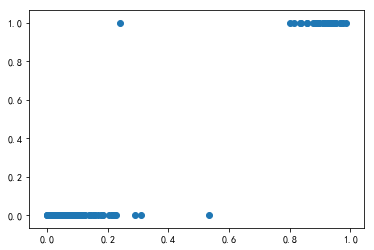

In [25]:
plt.scatter(outputs.cpu().detach().numpy(), scores.cpu().detach().numpy())
plt.show()

In [34]:
(-(outputs.round() == scores).float()).topk(5)

(tensor([-0., -0., -1., -1., -1.], device='cuda:0'),
 tensor([ 109,  104,    2,    1,    0], device='cuda:0'))

In [35]:
p[109]

'I ll take you to my place'

In [18]:
import pandas as pd
allresult = pd.read_json("others/result.json")[["epoch", "pre", "next", "make"]]

In [19]:
epoch = 1
fullResult = pd.DataFrame()
while True:
    result = allresult.loc[allresult['epoch'] == epoch].copy(True)
    if len(result) == 0:
        break
    vpres = sentenceToVector(result["pre"], lang)
    vnexts = sentenceToVector(result["make"], lang)
    outputs = model(vpres, vnexts)
    part = result
    part["score"] = outputs.detach()
    fullResult = fullResult.append(part, ignore_index=True)
    epoch += 1

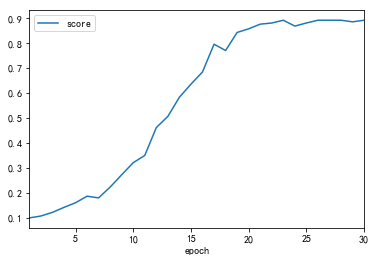

In [20]:
fullResult.groupby("epoch").mean().plot()
plt.show()

count    64.000000
mean      0.891663
std       0.080187
min       0.498750
25%       0.868344
50%       0.912489
75%       0.940957
max       0.987363
Name: score, dtype: float64


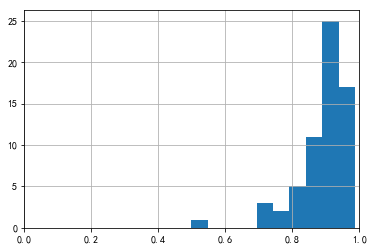

In [21]:
partDatas = fullResult.loc[fullResult['epoch'] == 30]
partDatas["score"].hist().set_xlim(0,1)
print(partDatas["score"].describe())
plt.show()

In [109]:
partDatas.loc[partDatas['score'] <= .8]

,epoch,pre,next,make,score
1858,30,I can t get a signal,What s your Wi Fi password,What s your Wi Fi password,0.742746
1869,30,Forget the tangerine,Earl s having a heart attack,Earl s having a heart attack,0.720413
1877,30,Then I realized when you have the right to bea...,Omelet Pick up,Omelet Pick up,0.779002
1878,30,The rest of my Cinnabon,Max that s our competition,Max that s our competition,0.697891
1900,30,Oh,Oh my God,Oh my God,0.498750
1909,30,She missed my birth cause she had a thing,Come on she can t be that bad,Come on she can t be that bad,0.791762


In [101]:
qerror = partDatas.loc[[1901]]
qerror

,epoch,pre,next,make,score
1901,30,No I got this,I got this,I got this,0.923086


In [102]:
vpres = sentenceToVector(qerror["pre"], lang)
vnexts = sentenceToVector(qerror["make"], lang)
s1Sentence, s1Lengths = vpres
s2Sentence, s2Lengths = vnexts

In [103]:
from utils.tool import getLastOutputs
feature1, _ = model.preEncoder(s1Sentence)
feature2, _ = model.nextEncoder(s2Sentence)

feature1 = getLastOutputs(feature1, s1Lengths)
feature2 = getLastOutputs(feature2, s2Lengths)

In [104]:
model.gesd(feature1, feature2)

tensor([ 0.9231], device='cuda:0')

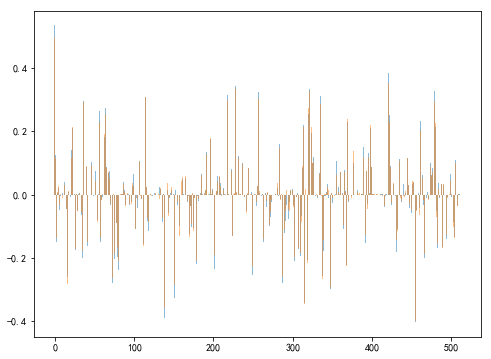

In [107]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
x = range(0, feature1[0].size(0))
plt.bar(x, feature1[0].detach(), alpha=0.5)
plt.bar(x, feature2[0].detach(), alpha=0.5)
plt.show()